In [1]:
from mmot import MMOTSolver

import numpy as np 
import matplotlib.pyplot as plt 
import itertools

## Download and open the MNIST dataset

In [2]:
import hashlib 
import os 
import requests 
import gzip

#fetch data (adapted from https://github.com/geohot/ai-notebooks/blob/master/mnist_from_scratch.ipynb)
path='./'
def fetch(url):
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

digits = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
labels = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]

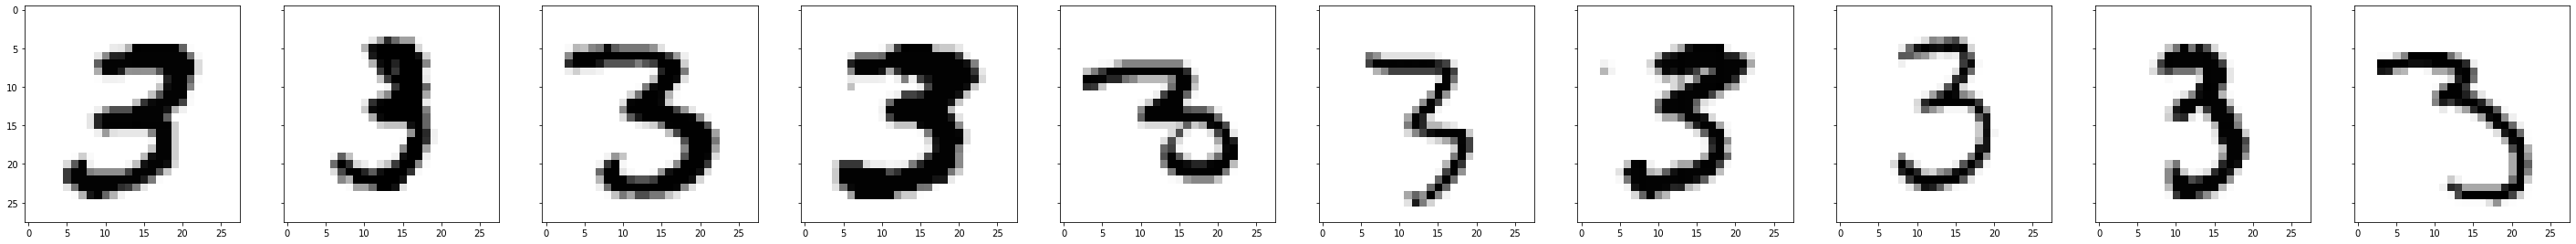

In [3]:
desired_digit = 3
inds = np.where(labels==desired_digit)[0]

num_plot = 10 
fig,axs = plt.subplots(ncols=num_plot, sharey=True, figsize=(num_plot*5,5))
for i in range(num_plot):
    axs[i].imshow(digits[inds[i],:,:],cmap='Greys')


In [4]:
# Grid of size n1 x n2
n1 = digits.shape[1]   # x axis
n2 = digits.shape[2]   # y axis

x, y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))


### Extract digits with similar total measure

0


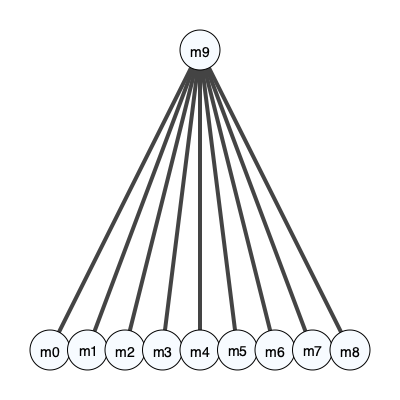

In [5]:
unroll_node = 0

num_digits = 10 
sums = np.array([np.sum(digits[i,:,:]) for i in inds])

val = np.sum(digits[inds[0],:,:])

sorted_inds = inds[np.argsort(np.abs(sums-val))]
measures = [digits[sorted_inds[i],:,:]* (n1*n2/np.sum(digits[sorted_inds[i],:,:])) for i in range(num_digits)]

edge_list = []
for i in range(num_digits):
    for j in range(i+1,num_digits):
        edge_list += [[i,j]]


prob = MMOTSolver(measures, edge_list, x, y, unroll_node)

prob.Visualize('original', filename='CostGraph.svg')

Iteration, StepSize,    Cost,   Error
        0,   0.2000,  0.0184,   0.64792
       10,   0.1000,  0.1396,   0.10345
       20,   0.1000,  0.1559,   0.05676
       30,   0.0500,  0.1634,   0.04822
       40,   0.0500,  0.1700,   0.05003
       50,   0.0500,  0.1807,   0.03832
       60,   0.0250,  0.1847,   0.03494
       70,   0.0250,  0.1884,   0.03365
       80,   0.0250,  0.1916,   0.03376
       90,   0.0250,  0.1941,   0.03526
      100,   0.0125,  0.1953,   0.03255
      110,   0.0125,  0.1965,   0.03171
      120,   0.0125,  0.1980,   0.03123
      130,   0.0063,  0.1987,   0.03185
      140,   0.0063,  0.1997,   0.03171
      150,   0.0063,  0.2002,   0.03137
      160,   0.0063,  0.2008,   0.03116
      170,   0.0031,  0.2013,   0.03117
      180,   0.0031,  0.2017,   0.03183
      190,   0.0016,  0.2020,   0.03114
      200,   0.0031,  0.2023,   0.03144
      210,   0.0031,  0.2025,   0.03100
      220,   0.0016,  0.2028,   0.03087
      230,   0.0031,  0.2031,   0.03067
  

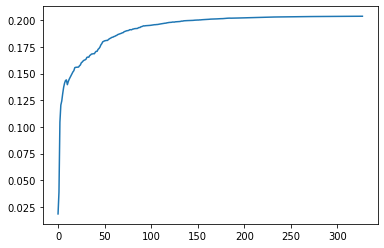

In [17]:
dual_vars = [np.zeros(x.shape) for i in range(prob.NumDual())]

num_its = 10000
step_size = 0.2
ftol = 1e-7
gtol = 1e-3

root_node = 0
costs = np.nan*np.zeros(num_its)

root_nodes = np.arange(prob.NumDual())
root_cycler = itertools.cycle(root_nodes)

print('Iteration, StepSize,    Cost,   Error')
for i in range(num_its):
    error = prob.Step(next(root_cycler), dual_vars, step_size)
    
    costs[i] = prob.ComputeCost(dual_vars)
    if(i>0):
        step_size = prob.StepSizeUpdate(step_size, costs[i], costs[i-1], error)

    if((i%10)==0):
        print('{:9d},   {:0.4f},  {:0.4f},   {:0.5f}'.format(i,step_size, costs[i], error))

    # Check for convergence in cost
    if(np.abs(costs[i]-costs[i-1])<ftol):
        break

    # Check for convergence via gradient 
    if(error<gtol):
        break 
    
plt.plot(costs)
plt.show()

In [15]:
weights = np.ones(num_digits)/num_digits
bary = prob.Barycenter(dual_vars, weights)


Text(0.5, 1.0, 'Barycenter')

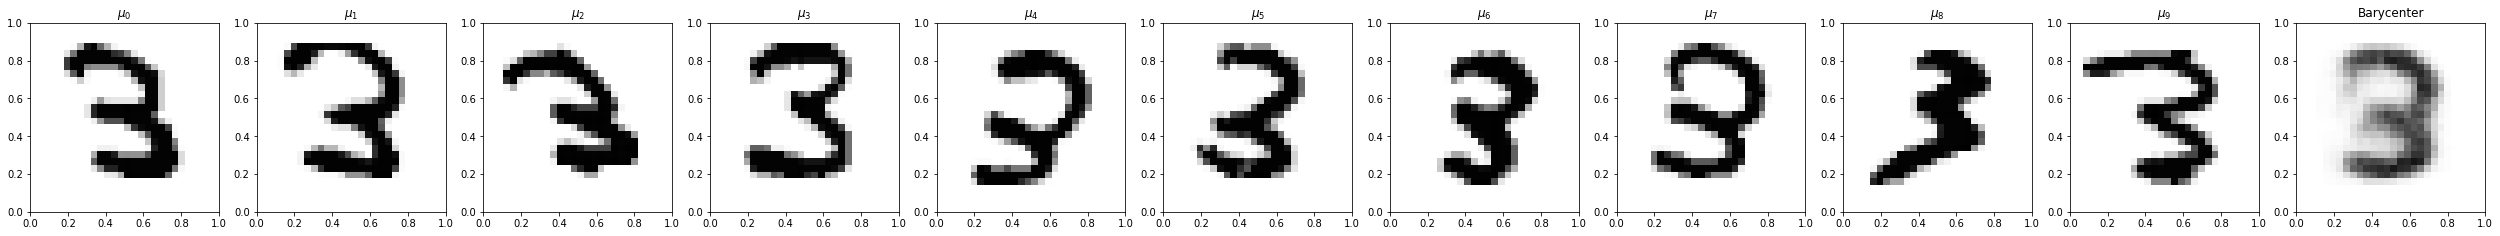

In [16]:
vmax = np.max([np.max(m) for m in measures])
fig, axs = plt.subplots(1, num_digits+1, figsize=((num_digits+1)*4,4))
for i in range(num_digits):
    axs[i].imshow(measures[i], origin='lower', extent=(0,1,0,1), vmin=0, vmax=vmax, cmap='Greys')
    axs[i].set_title("$\\mu_{{ {:0d} }}$".format(i))
    
axs[-1].imshow(bary, origin='lower', extent=(0,1,0,1), vmin=0, vmax=vmax, cmap='Greys')
axs[-1].set_title('Barycenter')
